## Import libraries

In [5]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as Fun
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook
from My_ViT import VisionTransformer, img_to_patch


In [6]:
model = torch.load('./saved_model.pth')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print("Device:", device)
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



Device: mps


/var/folders/4t/vzt8rmpj2bzg8tyypgszxpqc0000gp/T/ipykernel_49684/3889230090.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./saved_model.pth')


In [7]:
image_size = 28
embed_dim=255
hidden_dim=embed_dim*3
num_heads=3
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

## Downloading FashionMNIST from torchvision

In [8]:
def random_transform(image):
  if random.random() < 0.5:  # 50% prob of applying a transformation
    if random.random() < 0.5:  # 50% prob of rotation
      angle = random.choice([0, 90, 180, 270])
      image = Fun.rotate(image, angle)
    else:  # otherwise translation
      translate = (random.uniform(0, 0.1), random.uniform(0, 0.1))
      image = Fun.affine(image, angle=0, translate=translate, scale=1, shear=0)
  return image

# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([
  T.Lambda(random_transform), #apply random transformation
  T.ToTensor(),
  T.Normalize((0.5,), (0.5,))])
# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

## Picking one test sample and running it through the first attention block

In [9]:
test_sample_index = (test_set.targets==7).nonzero(as_tuple=True)[0][7].item()

In [10]:
# pull out one test sample
#img_tensor = test_set.data[test_sample_index].to(device)
img_tensor = test_set[test_sample_index][0].squeeze().to(device)
img_tensor = (img_tensor * 255).clamp(0, 255).byte()
print(img_tensor.dtype)

# convert the test sample into patches
patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
# run the patches through the input layer to get a tensor of size embed_dim
patches = model.input_layer(patches.float())
# attach the class token and add the position embedding
transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
print("Input tensor to Transformer: ", transformer_input.shape)
# run the embedded test image through the first attention block and squeeze the
# batch dimension because we're only using one test image
transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
print("transformer_input_expanded shape: ", transformer_input_expanded.shape)

torch.float32
torch.uint8
Input tensor to Transformer:  torch.Size([1, 17, 255])
transformer_input_expanded shape:  torch.Size([17, 765])


In [11]:
# reshape the output of the first attention block to be of size (num_patches+1, 3, num_heads, -1)
qkv = transformer_input_expanded.reshape(num_patches+1, 3, num_heads, -1)
print("qkv shape: ", qkv.shape)
# pull the query matrix and permute the dimensions to be (8 heads, 17 patches, 32 channels)
# do the same for the key matrix
q = qkv[:, 0].permute(1, 0, 2)
k = qkv[:, 1].permute(1, 0, 2)
print("q shape: ", q.shape)
print("k shape: ", k.shape)
kT = k.permute(0, 2, 1)
# The result of multiplying q @ kT is a squared matrix 17 by 17 showing how each
# patch is "paying attention" to every other patch
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)

qkv shape:  torch.Size([17, 3, 3, 85])
q shape:  torch.Size([3, 17, 85])
k shape:  torch.Size([3, 17, 85])
attention matrix:  torch.Size([3, 17, 17])


In [12]:
# Average the attention weights across all heads by taking the mean along
# the first dimension
attention_matrix_mean = torch.mean(attention_matrix, dim=0)
print("attention matrix mean: ", attention_matrix_mean.shape)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
# Please refer to the attention rollout paper: https://arxiv.org/abs/2005.00928
residual_att = torch.eye(attention_matrix_mean.size(1)).to(device)
aug_att_mat = attention_matrix_mean + residual_att
print("augmented attention matrix: ", aug_att_mat.shape)
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
print("normalized augmented attention matrix: ", aug_att_mat.shape)

attention matrix mean:  torch.Size([17, 17])
augmented attention matrix:  torch.Size([17, 17])
normalized augmented attention matrix:  torch.Size([17, 17])


## Plotting attention
Now we have a normalized squared matrix of size $17\times 17$. When plotting the first column is the class token. The remaining $16$ columns will be reshaped into a $4\times 4$ matrix, ordered in a way where each patch has its position in the image. For better visualization, we'll use `interpolate` function to resize the $4\times 4$ matrix to $28\times 28$.

attn_heatmap:  torch.Size([4, 4])
attn_heatmap_resized:  torch.Size([28, 28, 1])


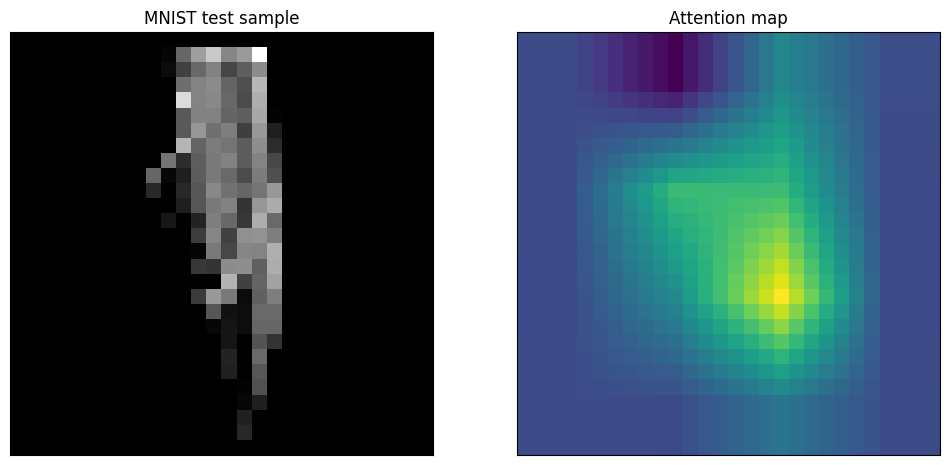

In [13]:
attn_heatmap = aug_att_mat[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
print("attn_heatmap: ", attn_heatmap.shape)

attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
print("attn_heatmap_resized: ", attn_heatmap_resized.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.imshow(attn_heatmap_resized.detach().cpu().numpy())
ax2.set_title('Attention map')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

In [14]:
# Prendi il valore minimo tra tutte le attention heads lungo la prima dimensione
attention_matrix_min, _ = torch.min(attention_matrix, dim=0)
print("attention matrix min: ", attention_matrix_min.shape)

# Aggiungi una matrice identità per tenere conto delle residual connections
residual_att = torch.eye(attention_matrix_min.size(1)).to(device)
aug_att_mat = attention_matrix_min + residual_att
print("augmented attention matrix: ", aug_att_mat.shape)

# Normalizza la matrice di attenzione
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
print("normalized augmented attention matrix: ", aug_att_mat.shape)


attention matrix min:  torch.Size([17, 17])
augmented attention matrix:  torch.Size([17, 17])
normalized augmented attention matrix:  torch.Size([17, 17])


attn_heatmap:  torch.Size([4, 4])
attn_heatmap_resized:  torch.Size([28, 28, 1])


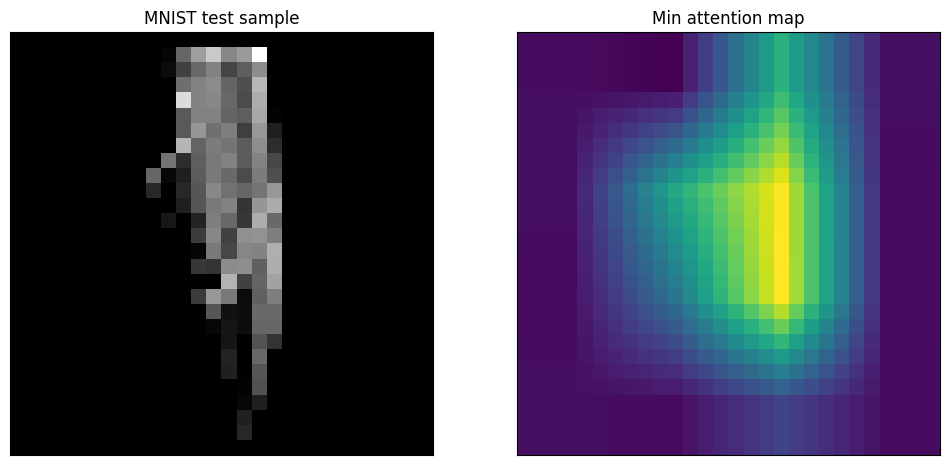

In [16]:
attn_heatmap = aug_att_mat[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
print("attn_heatmap: ", attn_heatmap.shape)
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
print("attn_heatmap_resized: ", attn_heatmap_resized.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.imshow(attn_heatmap_resized.detach().cpu().numpy())
ax2.set_title('Min attention map')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

In [17]:
# Prendi il valore massimo tra tutte le attention heads lungo la prima dimensione
attention_matrix_max, _ = torch.max(attention_matrix, dim=0)
print("attention matrix max: ", attention_matrix_max.shape)

# Aggiungi una matrice identità per tenere conto delle residual connections
residual_att = torch.eye(attention_matrix_max.size(1)).to(device)
aug_att_mat = attention_matrix_max + residual_att
print("augmented attention matrix: ", aug_att_mat.shape)

# Normalizza la matrice di attenzione
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
print("normalized augmented attention matrix: ", aug_att_mat.shape)


attention matrix max:  torch.Size([17, 17])
augmented attention matrix:  torch.Size([17, 17])
normalized augmented attention matrix:  torch.Size([17, 17])


attn_heatmap:  torch.Size([4, 4])
attn_heatmap_resized:  torch.Size([28, 28, 1])


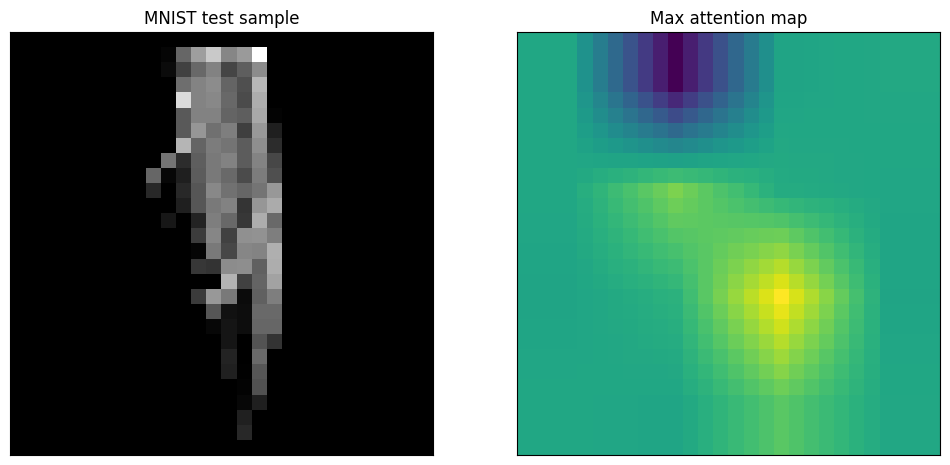

In [18]:
attn_heatmap = aug_att_mat[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
print("attn_heatmap: ", attn_heatmap.shape)
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
print("attn_heatmap_resized: ", attn_heatmap_resized.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.imshow(attn_heatmap_resized.detach().cpu().numpy())
ax2.set_title('Max attention map')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)